<img src="https://5264302.fs1.hubspotusercontent-na1.net/hubfs/5264302/Demo%20Asset%20Resources/Demo%20Covers/CM-Demo-pool_tvl-Cover.png" width=1100 margin-left='auto' margin-right='auto'/>

Automated Market Makers (AMMs) are an innovative new class of smart contracts introduced in decentralized exchange protocols like Uniswap, allowing users to permissionlessly provision liquidity for digital asset trading activity without needing a traditional central order book. However, an important aspect of providing users of these pools is understanding how the total USD value of the assets allocated to the contract can fluctuate over time, leading to impermanent loss for liquidity providers. In this notebook, we explore how Coin Metrics DEX market metadata can be combined with Reference Rates and ATLAS search engine capabilities to construct a timeseries representation pool TVL, allowing market participants to make more informed decisions about DEX market making and trading.

## Resources
This notebook demonstrates basic functionality offered by the Coin Metrics Python API Client, ATLAS blockchain search engine, and DEX Market Data.

Coin Metrics offers a vast assortment of data for hundreds of cryptoassets. The Python API Client allows for easy access to this data using Python without needing to create your own wrappers using `requests` and other such libraries.

To understand the data that Coin Metrics offers, feel free to peruse the resources below.

- The [Coin Metrics API v4](https://docs.coinmetrics.io/api/v4) website contains the full set of endpoints and data offered by Coin Metrics.
- The [Coin Metrics Knowledge Base](https://docs.coinmetrics.io/info) gives detailed, conceptual explanations of the data that Coin Metrics offers.
- The [API Spec](https://coinmetrics.github.io/api-client-python/site/api_client.html) contains a full list of functions.





## Notebook Setup

In [28]:
from os import environ
import sys
import pandas as pd
import numpy as np
import logging
from datetime import date, datetime, timedelta
from coinmetrics.api_client import CoinMetricsClient
import plotly.graph_objs as go
import logging
from pytz import timezone as timezone_conv
from datetime import timezone as timezone_info
from dateutil.relativedelta import relativedelta
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
%matplotlib inline

In [29]:
logging.basicConfig(
    format='%(asctime)s %(levelname)-8s %(message)s',
    level=logging.INFO,
    datefmt='%Y-%m-%d %H:%M:%S'
)

In [30]:
# We recommend privately storing your API key in your local environment.
try:
    api_key = environ["CM_API_KEY"]
    logging.info("Using API key found in environment")
except KeyError:
    api_key = ""
    logging.info("API key not found. Using community client")
    
client = CoinMetricsClient(api_key)

2024-10-09 14:36:29 INFO     Using API key found in environment


# DEX Market Reference Data

The *reference-data/markets* endpoint returns a list of available markets meeting specified criteria. Users can pass in a list of markets, exchanges, or market types (spot, futures, options). For DEX markets, the endpoint also returns key liquidity pool metadata, such as fee tier and pool contract address. 

In [31]:
uni_v3_markets = client.reference_data_markets(
    exchange = 'uniswap_v3_eth'
).to_dataframe()

In [32]:
uni_v3_markets

,market,exchange,base,quote,pair,symbol,type,size_asset,margin_asset,strike,...,order_price_increment,order_price_min,order_price_max,order_size_min,order_taker_fee,order_maker_fee,margin_trading_enabled,experimental,base_native,quote_native
0,uniswap_v3_eth-1-1inch-dai-spot,uniswap_v3_eth,1inch,dai,1inch-dai,<NA>,spot,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,True,<NA>,<NA>
1,uniswap_v3_eth-1-1inch-usdc-spot,uniswap_v3_eth,1inch,usdc,1inch-usdc,<NA>,spot,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,True,<NA>,<NA>
2,uniswap_v3_eth-1-1inch-weth-spot,uniswap_v3_eth,1inch,weth,1inch-weth,<NA>,spot,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,True,<NA>,<NA>
3,uniswap_v3_eth-1-ageur_eth-eurcv_eth-spot,uniswap_v3_eth,ageur_eth,eurcv_eth,ageur_eth-eurcv_eth,<NA>,spot,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,True,<NA>,<NA>
4,uniswap_v3_eth-1-ageur_eth-usdc-spot,uniswap_v3_eth,ageur_eth,usdc,ageur_eth-usdc,<NA>,spot,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,True,<NA>,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1638,uniswap_v3_eth-agg-yfi-cvx-spot,uniswap_v3_eth,yfi,cvx,yfi-cvx,<NA>,spot,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,True,<NA>,<NA>
1639,uniswap_v3_eth-agg-yfi-link-spot,uniswap_v3_eth,yfi,link,yfi-link,<NA>,spot,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,True,<NA>,<NA>
1640,uniswap_v3_eth-agg-yfi-usdc-spot,uniswap_v3_eth,yfi,usdc,yfi-usdc,<NA>,spot,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,True,<NA>,<NA>
1641,uniswap_v3_eth-agg-yfi-wbtc-spot,uniswap_v3_eth,yfi,wbtc,yfi-wbtc,<NA>,spot,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,True,<NA>,<NA>


In [33]:
weth_usdc_markets = uni_v3_markets.loc[(uni_v3_markets['base']=='usdc') & (uni_v3_markets['quote']=='weth')]

In [34]:
weth_usdc_pools = weth_usdc_markets.dropna(subset=['contract_address'])
weth_usdc_pools

,market,exchange,base,quote,pair,symbol,type,size_asset,margin_asset,strike,...,order_price_increment,order_price_min,order_price_max,order_size_min,order_taker_fee,order_maker_fee,margin_trading_enabled,experimental,base_native,quote_native
72,uniswap_v3_eth-1-usdc-weth-spot,uniswap_v3_eth,usdc,weth,usdc-weth,<NA>,spot,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,True,<NA>,<NA>
281,uniswap_v3_eth-2-usdc-weth-spot,uniswap_v3_eth,usdc,weth,usdc-weth,<NA>,spot,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,True,<NA>,<NA>
650,uniswap_v3_eth-3-usdc-weth-spot,uniswap_v3_eth,usdc,weth,usdc-weth,<NA>,spot,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,True,<NA>,<NA>
1045,uniswap_v3_eth-4-usdc-weth-spot,uniswap_v3_eth,usdc,weth,usdc-weth,<NA>,spot,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,True,<NA>,<NA>


## Fetch contract balances over time with ATLAS
Now that we have a list of target liquidity pool contracts, we can use ATLAS blockchain search engine to query for balance updates in the pool for each asset.

In [35]:
assets = ['usdc','weth']
pools = weth_usdc_pools['contract_address'].to_list()
pools_tvl = pd.DataFrame()
start = datetime.now() - timedelta(days=30)

for asset in assets:
    tvl = client.get_list_of_balance_updates_v2(
        asset=asset,
        accounts=pools,
        start_time = start
    ).parallel(max_workers=10,time_increment=relativedelta(days=1)).to_dataframe()
    
    # Add the asset name to a new 'asset' column
    tvl['asset'] = asset
    pools_tvl = pd.concat([pools_tvl, tvl], axis=0)

Exporting to dataframe type: 100%|█████████████████████████████████████████████████████████████| 31/31 [00:41<00:00,  1.34s/it]


In [36]:
# Create a mapping from contract_address to market
contract_to_market = weth_usdc_pools.set_index('contract_address')['market']
contract_to_market

contract_address
e0554a476a092703abdb3ef35c80e0d76d32939f    uniswap_v3_eth-1-usdc-weth-spot
88e6a0c2ddd26feeb64f039a2c41296fcb3f5640    uniswap_v3_eth-2-usdc-weth-spot
8ad599c3a0ff1de082011efddc58f1908eb6e6d8    uniswap_v3_eth-3-usdc-weth-spot
7bea39867e4169dbe237d55c8242a8f2fcdcc387    uniswap_v3_eth-4-usdc-weth-spot
Name: market, dtype: string

In [37]:
pools_tvl['market'] = pools_tvl['account'].map(contract_to_market)

In [38]:
pools_tvl

,chain_sequence_number,account,account_creation_height,change,previous_balance,new_balance,transaction_sequence_number,n_debits,n_credits,block_hash,...,consensus_time,credit,total_received,total_sent,previous_debit_height,previous_credit_height,previous_chain_sequence_number,txid,asset,market
0,88964646899286016,88e6a0c2ddd26feeb64f039a2c41296fcb3f5640,12376729,-60426.466497,72674047.982769,72613621.516272,0,4019999,3619510,96131a3e3702feb38e1ce25c71773962cdf6ed8beb5ee2...,...,2024-09-09 14:37:23+00:00,False,738732040663.426392,738659427041.910034,20713695,20713694,88964642604318722,a8f5e44bb9ae9f93a3d1b11b5fce58fe2bcad8ba73561f...,usdc,uniswap_v3_eth-2-usdc-weth-spot
1,88964646899286022,88e6a0c2ddd26feeb64f039a2c41296fcb3f5640,12376729,-551.745218,72613621.516272,72613069.771054,0,4020000,3619510,96131a3e3702feb38e1ce25c71773962cdf6ed8beb5ee2...,...,2024-09-09 14:37:23+00:00,False,738732040663.426392,738659427593.655396,20713696,20713694,88964646899286016,3072cd48442d1e61b7232590812737dabdd52d60ed2181...,usdc,uniswap_v3_eth-2-usdc-weth-spot
2,88964651194253318,88e6a0c2ddd26feeb64f039a2c41296fcb3f5640,12376729,-1189.382003,72613069.771054,72611880.389051,0,4020001,3619510,d1b93582ac0242d6c4d78a2e15fa7a14cb8f23cdd315a7...,...,2024-09-09 14:37:35+00:00,False,738732040663.426392,738659428783.037231,20713696,20713694,88964646899286022,785845bb01a0c4c95a4fce1a5b684b607eff59db5e35a0...,usdc,uniswap_v3_eth-2-usdc-weth-spot
3,88964651194253320,e0554a476a092703abdb3ef35c80e0d76d32939f,13616454,-1185.605465,601863.20449,600677.599025,1,231967,225267,d1b93582ac0242d6c4d78a2e15fa7a14cb8f23cdd315a7...,...,2024-09-09 14:37:35+00:00,False,5991391248.046802,5990790570.447777,20713695,20713695,88964642604318733,785845bb01a0c4c95a4fce1a5b684b607eff59db5e35a0...,usdc,uniswap_v3_eth-1-usdc-weth-spot
4,88964651194253338,88e6a0c2ddd26feeb64f039a2c41296fcb3f5640,12376729,-1178.099514,72611880.389051,72610702.289537,0,4020002,3619510,d1b93582ac0242d6c4d78a2e15fa7a14cb8f23cdd315a7...,...,2024-09-09 14:37:35+00:00,False,738732040663.426392,738659429961.136841,20713697,20713694,88964651194253318,e8c9bf688ee4d41f22d95f34936a425edb4f61244318b7...,usdc,uniswap_v3_eth-2-usdc-weth-spot
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
273787,89893038440054825,e0554a476a092703abdb3ef35c80e0d76d32939f,13616454,11.45984,2397.232798,2408.692638,1,292522,301912,de4360d0ae6f824e4ca7525da2268497de62906fec744c...,...,2024-10-09 18:33:11+00:00,True,4128265.590843,4125856.898204,20929853,20929850,89893034145087672,aefc38b1fa84766bb2e50b8565d7e6b23031d98a28ccd8...,weth,uniswap_v3_eth-1-usdc-weth-spot
273788,89893038440054892,e0554a476a092703abdb3ef35c80e0d76d32939f,13616454,-0.015523,2408.692638,2408.677115,0,292523,301912,de4360d0ae6f824e4ca7525da2268497de62906fec744c...,...,2024-10-09 18:33:11+00:00,False,4128265.590843,4125856.913727,20929853,20929854,89893038440054825,9b83a0daab76cd6db6aedbafc5f1e61adc0f5d31e72e47...,weth,uniswap_v3_eth-1-usdc-weth-spot
273789,89893038440054968,88e6a0c2ddd26feeb64f039a2c41296fcb3f5640,12376729,-2.123209,27357.193086,27355.069877,0,3685872,4078043,de4360d0ae6f824e4ca7525da2268497de62906fec744c...,...,2024-10-09 18:33:11+00:00,False,378530260.402821,378502905.332944,20929852,20929854,89893038440054823,e79fe9981166fccb9fb15b872da4ee5f8ea4f581a86e0d...,weth,uniswap_v3_eth-2-usdc-weth-spot
273790,89893051324956808,88e6a0c2ddd26feeb64f039a2c41296fcb3f5640,12376729,-0.119392,27355.069877,27354.950485,0,3685873,4078043,2823efc897ab6e43f4382e7670f1cfa4aa621571e79d9d...,...,2024-10-09 18:33:47+00:00,False,378530260.402821,378502905.452336,20929854,20929854,89893038440054968,a46cab246dea451a42d4b26c79994c5fc06ce1a10a53a7...,weth,uniswap_v3_eth-2-usdc-weth-spot


In [39]:
# Sort by 'consensus_time', 'market', and 'chain_sequence_number'
pools_tvl_sorted = pools_tvl.sort_values(by=['consensus_time', 'market', 'chain_sequence_number'], ascending=[True, True, False])

# Drop duplicates, keeping only the first occurrence (in this case, the highest 'chain_sequence_number')
pools_tvl_deduplicated = pools_tvl_sorted.drop_duplicates(subset=['consensus_time', 'market','asset'], keep='first')

In [40]:
pools_tvl_clean = pools_tvl_deduplicated[['market','consensus_time','asset','new_balance']].copy()
pools_tvl_clean['new_balance'] = pools_tvl_clean.apply(
    lambda row: -row['new_balance'] if row['asset'] == 'weth' else row['new_balance'],
    axis=1
)
pools_tvl_clean

,market,consensus_time,asset,new_balance
1,uniswap_v3_eth-2-usdc-weth-spot,2024-09-09 14:37:23+00:00,weth,-3.126659e+04
1,uniswap_v3_eth-2-usdc-weth-spot,2024-09-09 14:37:23+00:00,usdc,7.261307e+07
3,uniswap_v3_eth-1-usdc-weth-spot,2024-09-09 14:37:35+00:00,weth,-4.664425e+02
3,uniswap_v3_eth-1-usdc-weth-spot,2024-09-09 14:37:35+00:00,usdc,6.006776e+05
4,uniswap_v3_eth-2-usdc-weth-spot,2024-09-09 14:37:35+00:00,weth,-3.126763e+04
...,...,...,...,...
273850,uniswap_v3_eth-2-usdc-weth-spot,2024-10-09 18:36:11+00:00,usdc,8.006068e+07
273853,uniswap_v3_eth-1-usdc-weth-spot,2024-10-09 18:36:23+00:00,usdc,2.503766e+06
273851,uniswap_v3_eth-2-usdc-weth-spot,2024-10-09 18:36:23+00:00,usdc,8.005964e+07
273854,uniswap_v3_eth-2-usdc-weth-spot,2024-10-09 18:36:47+00:00,usdc,8.005916e+07


In [41]:
df = pd.DataFrame(pools_tvl_clean)
df['consensus_time'] = pd.to_datetime(df['consensus_time'])
# Split the DataFrame by market and store in a dictionary
market_dfs = {market: group.pivot(index='consensus_time', columns='asset', values='new_balance').ffill()
              for market, group in df.groupby('market')}

In [42]:
display(market_dfs)

{'uniswap_v3_eth-1-usdc-weth-spot': asset                              usdc         weth
 consensus_time                                      
 2024-09-09 14:37:35+00:00  6.006776e+05  -466.442498
 2024-09-09 14:37:47+00:00  5.927582e+05  -469.913266
 2024-09-09 14:38:11+00:00  5.834235e+05  -474.007791
 2024-09-09 14:38:23+00:00  5.852796e+05  -473.193522
 2024-09-09 14:38:35+00:00  5.783144e+05  -476.250599
 ...                                 ...          ...
 2024-10-09 18:35:11+00:00  2.504156e+06 -2408.677115
 2024-10-09 18:35:35+00:00  2.507156e+06 -2408.677115
 2024-10-09 18:36:11+00:00  2.503081e+06 -2408.677115
 2024-10-09 18:36:23+00:00  2.503766e+06 -2408.677115
 2024-10-09 18:36:59+00:00  2.493272e+06 -2408.677115
 
 [93275 rows x 2 columns],
 'uniswap_v3_eth-2-usdc-weth-spot': asset                              usdc          weth
 consensus_time                                       
 2024-09-09 14:37:23+00:00  7.261307e+07 -31266.590416
 2024-09-09 14:37:35+00:00  7.2610

## Retrieve Reference Rates to calculate the equivalent USD value for TVL

To normalize pool TVL into USD-denominated terms, we'll leverage the Coin Metrics Reference Rate, which represents a volume-weighted median price across a subset of the asset's most highly-liquid markets.

In [43]:
ref_rate = client.get_asset_metrics(
    assets=['usdc','weth'],
    metrics='ReferenceRateUSD',
    start_time=start,
    frequency='1m'
).parallel(max_workers=10,time_increment=relativedelta(days=1)).to_dataframe()

Exporting to dataframe type: 100%|█████████████████████████████████████████████████████████████| 62/62 [00:06<00:00,  8.93it/s]


In [44]:
ref_rate = ref_rate.pivot(index='time', columns='asset', values='ReferenceRateUSD')
ref_rate

asset,usdc,weth
time,,
2024-09-09 14:38:00+00:00,1.000228,2281.628477
2024-09-09 14:39:00+00:00,1.000066,2278.047686
2024-09-09 14:40:00+00:00,0.99975,2279.877181
2024-09-09 14:41:00+00:00,0.999917,2278.211943
2024-09-09 14:42:00+00:00,0.999867,2279.118291
...,...,...
2024-10-09 18:34:00+00:00,0.999862,2422.199211
2024-10-09 18:35:00+00:00,0.999822,2418.294121
2024-10-09 18:36:00+00:00,0.999827,2420.816853


In [45]:
# Iterate over each market DataFrame
for market, df in market_dfs.items():
    # Resample the DataFrame to 1-minute intervals
    df_resampled = df.resample('min').last().dropna()

    # Reindex the market DataFrame to the ref_rate DataFrame's index
    aligned_df = df_resampled.reindex(ref_rate.index, method='nearest')

    # Multiply the 'usdc' and 'weth' columns by the corresponding rate
    aligned_df['usdc'] = aligned_df['usdc'] * ref_rate['usdc']
    aligned_df['weth'] = aligned_df['weth'] * ref_rate['weth']

    # Replace the original DataFrame in the dictionary with the updated one
    market_dfs[market] = aligned_df

In [46]:
first_pool_key = list(market_dfs.keys())[0]
first_pool = market_dfs[first_pool_key]  
first_pool

asset,usdc,weth
time,,
2024-09-09 14:38:00+00:00,580007.558512,-1085063.725878
2024-09-09 14:39:00+00:00,591547.333378,-1071736.155646
2024-09-09 14:40:00+00:00,591664.869298,-1072292.759274
2024-09-09 14:41:00+00:00,584444.264977,-1078824.970611
2024-09-09 14:42:00+00:00,604433.557236,-1059255.13815
...,...,...
2024-10-09 18:34:00+00:00,2480138.279715,-5834295.808101
2024-10-09 18:35:00+00:00,2506710.799699,-5824889.708489
2024-10-09 18:36:00+00:00,2492840.090089,-5830966.153299


## Plot USD-denominated TVL for target liquidity pools

In [47]:
def generate_area_figure(df, layout, columns, diverging_colors=False):
    traces = []
    for series in columns:
        traces.append(
            go.Scatter(
                x=df.index,
                y=df[series],
                name=series,
                fill='tozeroy'  # Ensures filling to the zero line on the y-axis
            ))
    return go.Figure(data=traces, layout=layout)

uniswap_v3_eth-1-usdc-weth-spot
e0554a476a092703abdb3ef35c80e0d76d32939f
USDC: https://atlas.coinmetrics.io/address-details?asset=usdc&address=e0554a476a092703abdb3ef35c80e0d76d32939f
WETH: https://atlas.coinmetrics.io/address-details?asset=weth&address=e0554a476a092703abdb3ef35c80e0d76d32939f


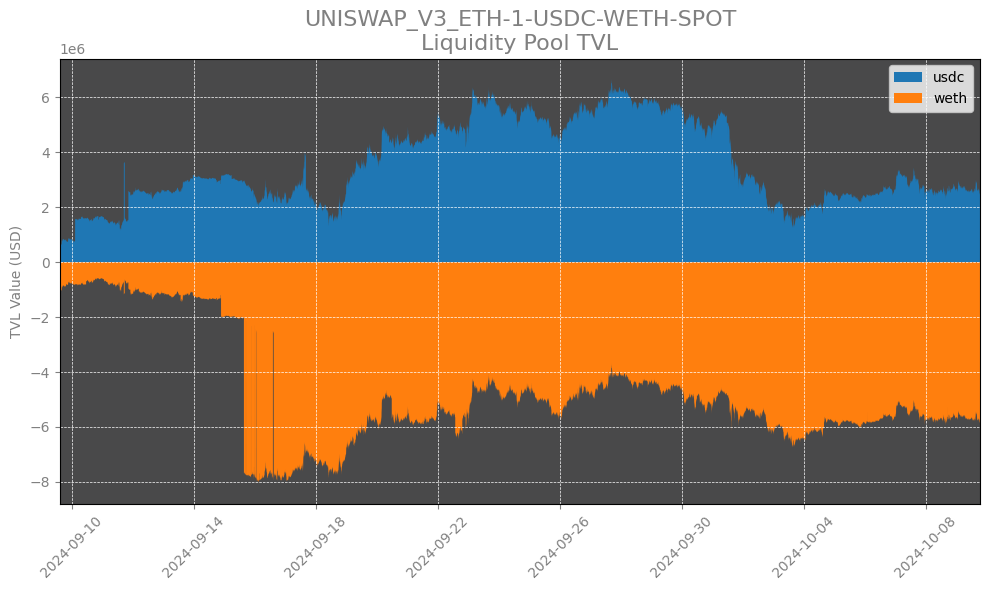

uniswap_v3_eth-2-usdc-weth-spot
88e6a0c2ddd26feeb64f039a2c41296fcb3f5640
USDC: https://atlas.coinmetrics.io/address-details?asset=usdc&address=88e6a0c2ddd26feeb64f039a2c41296fcb3f5640
WETH: https://atlas.coinmetrics.io/address-details?asset=weth&address=88e6a0c2ddd26feeb64f039a2c41296fcb3f5640


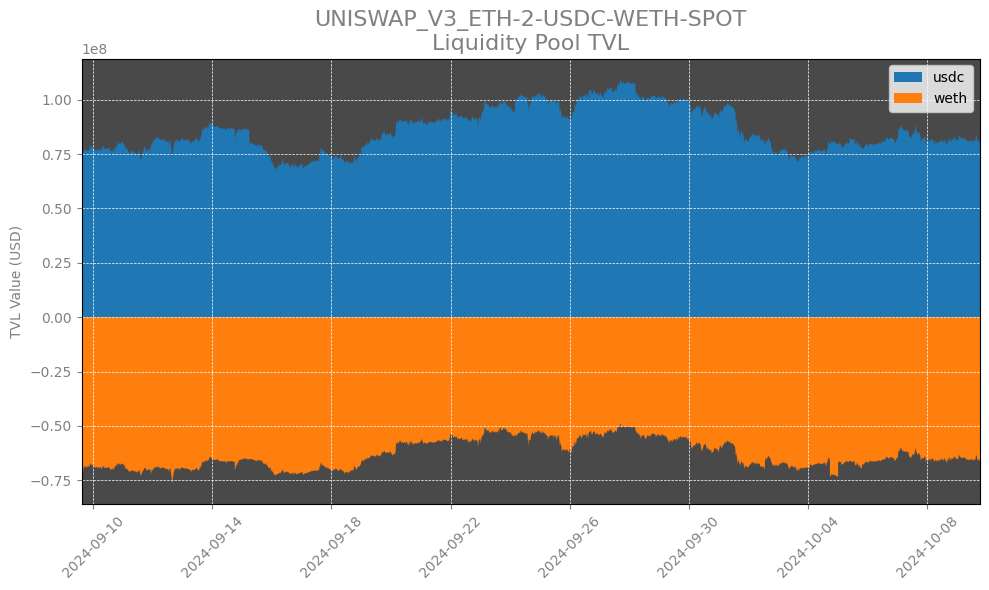

uniswap_v3_eth-3-usdc-weth-spot
8ad599c3a0ff1de082011efddc58f1908eb6e6d8
USDC: https://atlas.coinmetrics.io/address-details?asset=usdc&address=8ad599c3a0ff1de082011efddc58f1908eb6e6d8
WETH: https://atlas.coinmetrics.io/address-details?asset=weth&address=8ad599c3a0ff1de082011efddc58f1908eb6e6d8


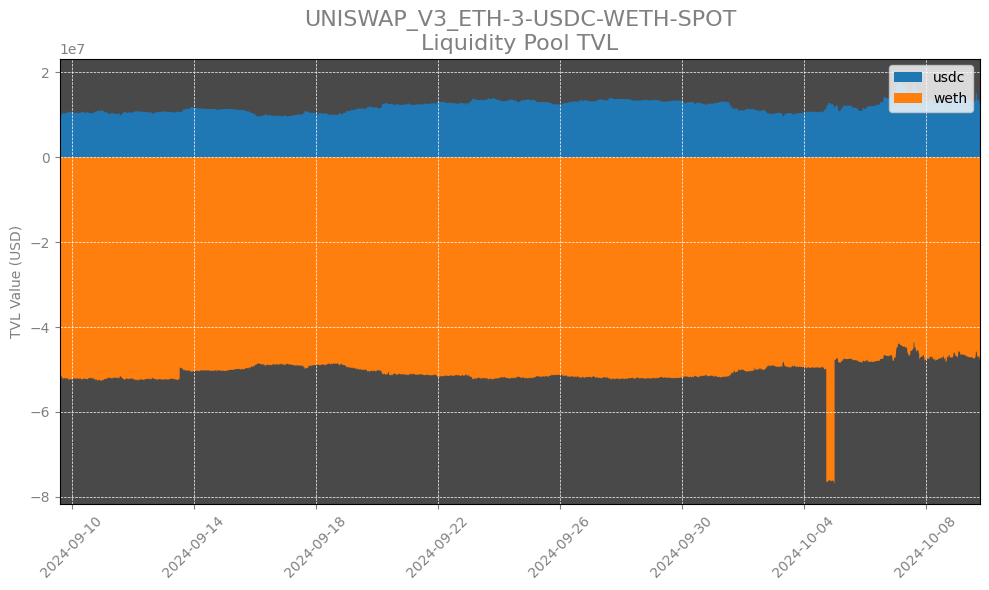

uniswap_v3_eth-4-usdc-weth-spot
7bea39867e4169dbe237d55c8242a8f2fcdcc387
USDC: https://atlas.coinmetrics.io/address-details?asset=usdc&address=7bea39867e4169dbe237d55c8242a8f2fcdcc387
WETH: https://atlas.coinmetrics.io/address-details?asset=weth&address=7bea39867e4169dbe237d55c8242a8f2fcdcc387


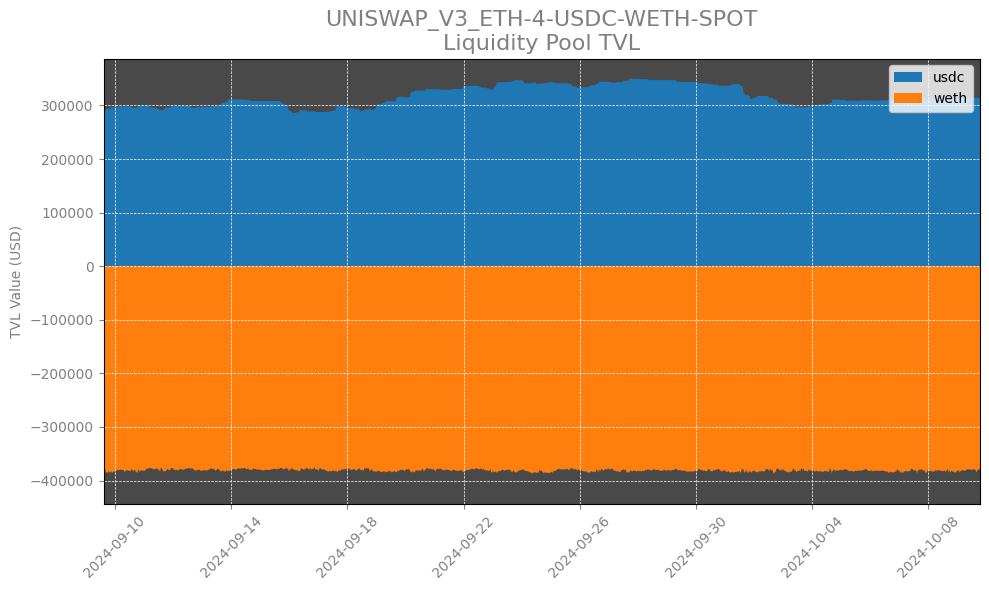

In [54]:
# Plotting for each market using Matplotlib
market_to_contract = contract_to_market.reset_index().set_index('market')
for market, data in market_dfs.items():
    address = market_to_contract.loc[market, 'contract_address']
    print(f'{market}')
    print(f'{address}')
    print(f'USDC: https://atlas.coinmetrics.io/address-details?asset=usdc&address={address}')
    print(f'WETH: https://atlas.coinmetrics.io/address-details?asset=weth&address={address}')

    # Create the figure and axis
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot the area chart for each series in the data
    for column in data.columns:
        ax.fill_between(data.index, data[column], label=column)

    # Set chart title and labels
    ax.set_title(f'{market.upper()}\nLiquidity Pool TVL', fontsize=16, color='grey')
    ax.set_xlabel('', color='grey')
    ax.set_ylabel('TVL Value (USD)', color='grey')

    # Set grid and background colors
    ax.set_facecolor('#49494a')
    ax.grid(True, color='white', linestyle='--', linewidth=0.5)

    # Customize tick parameters (color and size)
    ax.tick_params(axis='x', colors='grey', rotation=45)
    ax.tick_params(axis='y', colors='grey')
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=4))
    ax.set_xlim([data.index.min(), data.index.max()])

    # Set legend and its appearance
    ax.legend(loc='upper right', fontsize=10)

    # Adjust the plot layout
    plt.tight_layout()

    # Show the plot
    plt.show()